# pystackreg tutorial
This notebook demonstrates the uses of pystackreg on an example dataset of a live neuronal structure.

## Load dependencies

In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform, io, exposure

from pystackreg import StackReg
import pystackreg

In [2]:
print(pystackreg.__version__)

0.2.3rc1


In [3]:
def overlay_images(imgs, equalize=False, aggregator=np.mean):
    
    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]
    
    imgs = np.stack(imgs, axis=0)
    
    return aggregator(imgs, axis=0)

In [4]:
def composite_images(imgs, equalize=False, aggregator=np.mean):
    
    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]
    
    imgs = [img / img.max() for img in imgs]
    
    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))
  
    imgs = np.dstack(imgs)
    
    return imgs

# Load sample data

In [5]:
data_path = os.path.join(os.getcwd(), '..', 'data')
unreg = io.imread(os.path.join(data_path, 'gamma-unreg.tif'))

# convert to float to prevent overflows when calculating differences images
unreg = unreg.astype(np.float)

# Perform single image registration

In [6]:
transformations = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

In [7]:
#load reference and "moved" image
ref = unreg[0, :, :]
mov = unreg[4, :, :]

## Show original images

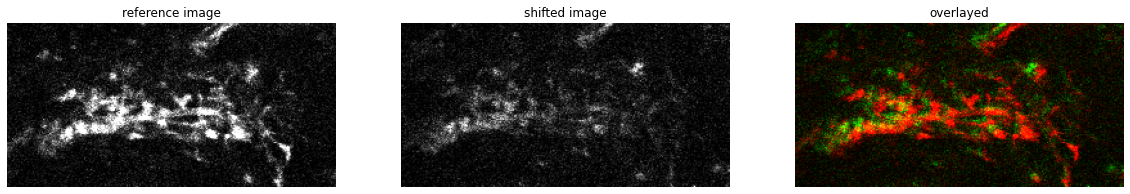

In [8]:
f, ax = plt.subplots(1, 3, figsize=(20, 9))

before_reg = composite_images([ref, mov])

ax[0].imshow(ref, cmap='gray')
ax[0].set_title('reference image')
ax[0].axis('off')

ax[1].imshow(mov, cmap='gray')
ax[1].set_title('shifted image')
ax[1].axis('off')

ax[2].imshow(before_reg)
ax[2].set_title('overlayed')
ax[2].axis('off');

As can be seen from the overlay image (right), the second image (middle) is shifted considerably with respect to the reference image (left).

## Transform shifted image

We will next use all available transformation modes from pystackreg to register the shifted image to the reference image.

In [9]:
def show_transformation(tmat, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    p = np.array([[1,120,1], [1,1,1], [250, 1, 1], [250,120,1], [1,120,1]])
    ax.plot(p[:, 0], p[:,1])
    q=np.dot(p, tmat.T)
    ax.plot(q[:, 0], q[:,1])
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend(['Original image', 'transformed image'])

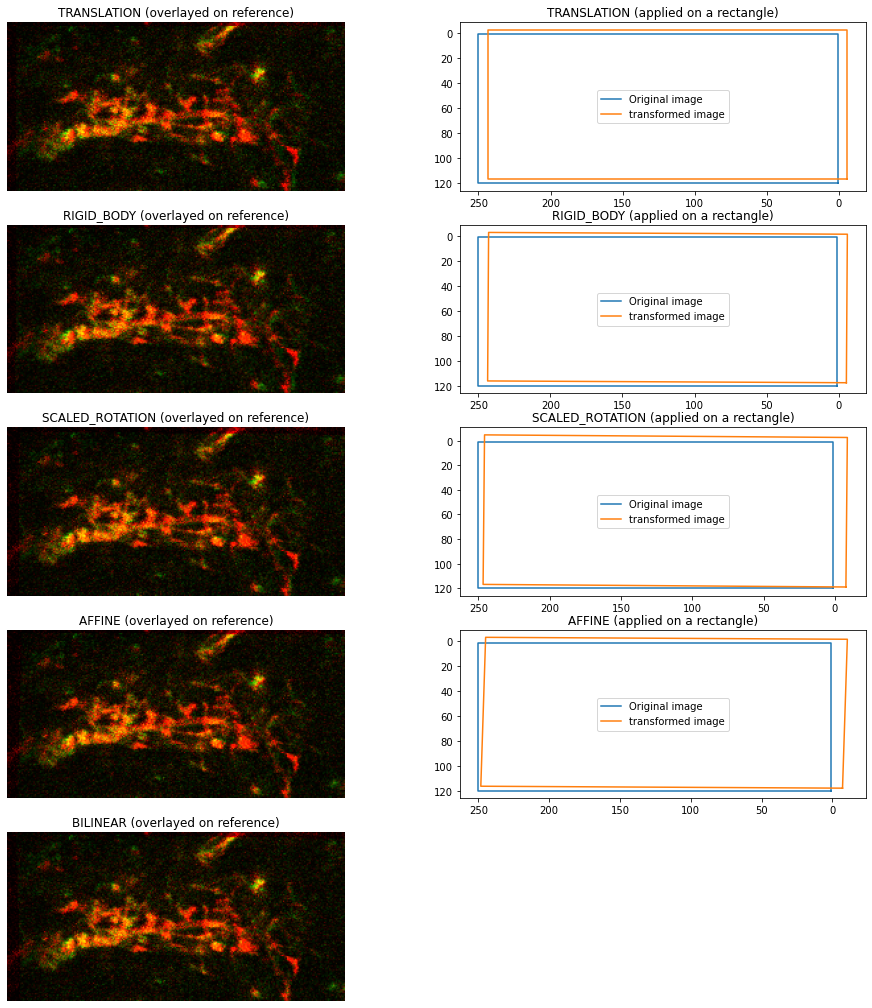

In [10]:
f, ax = plt.subplots(5, 2, figsize=(16, 18))

for i, (name, tf) in enumerate(transformations.items()):
    sr = StackReg(tf)
    reg = sr.register_transform(ref, mov)
    reg = reg.clip(min=0)
        
    after_reg =  composite_images([ref, reg])
    
    ax[i][0].imshow(after_reg, cmap='gray', vmin=0, vmax=1)
    ax[i][0].set_title(name + ' (overlayed on reference)')
    ax[i][0].axis('off')
    
    if name != 'BILINEAR':
        show_transformation(sr.get_matrix(), ax[i][1])
        ax[i][1].set_title(name + ' (applied on a rectangle)')
    else:
        ax[i][1].axis('off')

Translation already performs a quite good job at registering the images, but only affine and bilinear transformation also match the structures in the lower right of the images. 

In the right column, the action of the transformation matrix on a rectangle is shown.

# Perform stack transformations

In [11]:
print(f"Numer of images in the stack: {len(unreg)}")

Numer of images in the stack: 7


The original stack contains 7 images, we have so far only looked at the registration of two images out of that stack. We will next see how to use pystackreg to register the whole stack of 7 images.

## Show original images (overlayed)

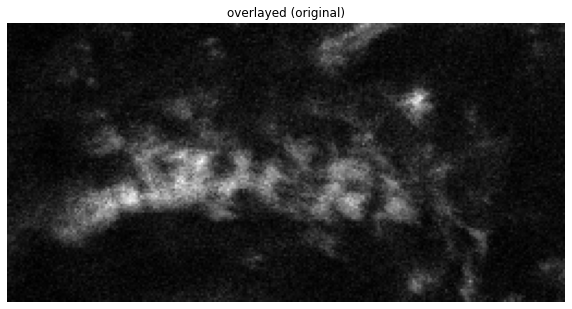

In [12]:
f, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.imshow(overlay_images(unreg), cmap='gray')
ax.set_title('overlayed (original)')
ax.axis('off');

The above image is the mean of each of the 7 images of the stack. As can bee seen, it is quite blurry due to the misalignment.

## Register and transform the whole stack

We will next use all 5 kinds of transformation offered by pystackreg to register the stack's images. Afterwards the average of the registered images is shown for each of the different types of transformations.

**Note** that we will save the transformation matrices of each transformation in a list `tmats` for later use.

100%|██████████| 6/6 [00:00<00:00, 24.36it/s]


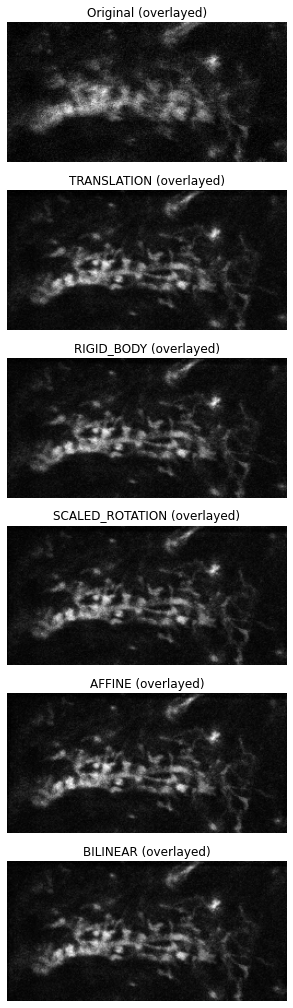

In [13]:
f, ax = plt.subplots(len(transformations)+1, 1, figsize=(16, 18))

ax[0].imshow(overlay_images(unreg, aggregator=np.mean), cmap='gray')
ax[0].set_title('Original (overlayed)')
ax[0].axis('off')

# store transformation matrices for later use in this variable
tmats = []

for i, (name, tf) in enumerate(transformations.items()):
    sr = StackReg(tf)
    
    reference = 'first' if name == 'BILINEAR' else 'previous'
    
    tmat = sr.register_stack(unreg, axis=0, reference=reference, verbose=True)
    reg = sr.transform_stack(unreg)
    
    tmats.append(tmat)
    
    ax[i+1].imshow(overlay_images(reg, aggregator=np.mean), cmap='gray')
    ax[i+1].set_title(name + ' (overlayed)')
    ax[i+1].axis('off')

As can bee seen, all types of transformation lead to a much clearer average image of the stack, equivalent to nicely registered images.

## Use saved transformation matrices

Note that in the above operation we have saved the transformation matrices generated from pystackreg in the variable `tmats`. We will now use the affine transformation implemented in skimage to perform  what pystackreg does in its `transform` functions using a different package. This will demonstrate that the transformation matrices supplied by pystackreg can be stored and used in any desired context even without having to use pystackreg.

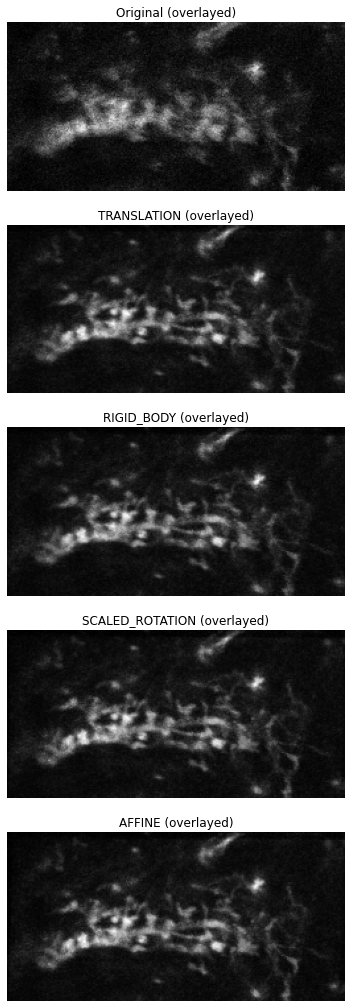

In [14]:
f, ax = plt.subplots(5, 1, figsize=(16, 18))

ax[0].imshow(overlay_images(unreg, aggregator=np.mean), cmap='gray')
ax[0].set_title('Original (overlayed)')
ax[0].axis('off')

for i, (name, tf) in enumerate(transformations.items()):
    
    if name == 'BILINEAR':
        # Bilinear transformation is not an affine transformation, we can't use the transformation matrix here
        continue
    
    # copy the unregistered image
    reg = unreg.copy()
    
    for i_img in range(unreg.shape[0]):
        # get skimage's AffineTransform object
        tform = transform.AffineTransform(matrix=tmats[i][i_img, :, :])
        
        # transform image using the saved transformation matrix
        reg[i_img, :, :] = transform.warp(reg[i_img, :, :], tform)
    
    
    ax[i+1].imshow(overlay_images(reg, aggregator=np.mean), cmap='gray')
    ax[i+1].set_title(name + ' (overlayed)')
    ax[i+1].axis('off')

# Custom callback for registration progress

The `register()` and `register_stack()` function can be called with a custom callback function that can be used to display progress information to the user.

The custom callback needs to accept the two parameters `current_iteration` and `end_iteration`:

In [15]:
def show_progress(current_iteration, end_iteration):
    print(f"Registering {current_iteration} of {end_iteration} images")


sr = StackReg(StackReg.RIGID_BODY)
reg = sr.register_transform_stack(unreg, axis=0, progress_callback=show_progress)

Registering 0 of 6 images
Registering 1 of 6 images
Registering 2 of 6 images
Registering 3 of 6 images
Registering 4 of 6 images
Registering 5 of 6 images


# Clipping of negative values
The transformation output of pystackreg is exactly equivalent to that of the ImageJ plugins TurboReg/StackReg on which it is based. The output of the transform function therefore has a `float` datatype and may contain negative values. To again create an image with integer values, the utility function `pystackreg.util.to_uint16()` can be used.

In [16]:
from pystackreg.util import to_uint16

In [17]:
sr = StackReg(StackReg.RIGID_BODY)
reg = sr.register_transform_stack(unreg)

print(f"The output of the transform function has the datatype {reg.dtype} with a minimal value of {reg.min()}")

The output of the transform function has the datatype float64 with a minimal value of -273.9885559082031


In [18]:
reg_int = to_uint16(reg)

print(f"After using the to_uint16 function, the output has a datatype {reg_int.dtype} with a minimal value of {reg_int.min()}")

After using the to_uint16 function, the output has a datatype uint16 with a minimal value of 0


# Registration of stacks having the frames/("time") not as the first axis
pystackreg expects the frames ("time") axis in a stacked image as the first axis, i.e. for a 3D numpy array, pystackreg expects the dimensions to be `frames x width x height`. pystackreg automatically tries to find out which axis is the frames axis and raises a warning if that axis is not the axis that the user supplied.

## Create test data

We will first create a stack that has the frames axis at axis 2 (instead of the default axis 0) by moving the axis from our sample data:

In [19]:
unreg.shape

(7, 128, 256)

In [20]:
unreg_axis = np.moveaxis(unreg, 0, 2)
unreg_axis.shape

(128, 256, 7)

## Register & transform
Next we register the stack using pystackreg's default parameters

In [21]:
sr = StackReg(StackReg.RIGID_BODY)
sr.register_stack(unreg_axis);

/home/lichtneg/anaconda3/envs/py36/lib/python3.6/site-packages/pystackreg-0.2.3rc1-py3.6-linux-x86_64.egg/pystackreg/pystackreg.py:349: UserWarning: Detected axis 2 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  lowest_var_axis, axis


Notice that this raises a warning as pystackreg correctly identified axis 2 as the frames axis. So let's use that axis for registration:

In [27]:
sr.register_stack(unreg_axis, axis=2);

Next transform the stack. Note that we need to supply the axis parameter again here - otherwise an error will be raised.

In [29]:
reg_axis = sr.transform_stack(unreg_axis, axis=2)